In [2]:
import numpy as np, pandas as pd
import os
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import requests
import sqlite3 as sql
import json
from bs4 import BeautifulSoup
import json
from PIL import Image
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
data_loc = os.getenv('PROJECT_PATH')
letterboxd_user_name = os.getenv('LETTERBOXD_USER')
film_db_path = os.getenv('WORKING_DB')
latest_export_file_loc = os.getenv('LATEST_EXPORT')
print('Latest export file location - {}'.format(latest_export_file_loc))

Latest export file location - C:/Users/tomdevine/Desktop/dev/PersonalProjects/letterboxd-app\db/raw_exports/letterboxd-td1138-2023-04-05-09-18-utc


## Let's define some functions for interacting with our database:

In [5]:
def db_info():
    '''
    prints out all of the columns of every table in db
    c : cursor object
    conn : database connection object
    '''
    db_conn = sql.connect(os.getenv('WORKING_DB'))
    connection_cursor = db_conn.cursor()
    tables = connection_cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    if len(tables) == 0:
        print('This database has no tables yet!')
    else:
        for table_name in tables:
            table_name = table_name[0] # tables is a list of single item tuples
            table = pd.read_sql_query("SELECT * from {} LIMIT 0".format(table_name), db_conn)
            print(table_name)
            for col in table.columns:
                print('\t' + col)
    db_conn.close()
    return None

In [6]:
# def df_to_table(df, table_name, replace_append='replace'):
#     db_conn = sql.connect(os.getenv('WORKING_DB'))
#     try:
#         df.columns = [col.upper() for col in df.columns]
#         df.to_sql(table_name, db_conn, if_exists=replace_append, index=False)
#         db_conn.close()
#         print('dataframe succesfully added to the database {} with the table name {}'.format(os.getenv('WORKING_DB'), table_name))
#     except:
#         db_conn.close()
#         print('Error - dataframe couldn\'t be added to the database')

In [7]:
def drop_table(table_name):
    db_conn = sql.connect(os.getenv('WORKING_DB'))
    try:
        drop_statement = 'DROP TABLE {}'.format(table_name)
        db_conn.cursor().execute(drop_statement)
        db_conn.close()
        return print('Table {} dropped successfully'.format(table_name))
    except:
        db_conn.close()
        return print('Error in dropping the table')

In [8]:
def table_to_df(table_name):
    db_conn = sql.connect(os.getenv('WORKING_DB'))
    select_statement = 'SELECT * FROM {}'.format(table_name)
    df = pd.read_sql(select_statement, db_conn)
    db_conn.close()
    return df

In [9]:
db_info()

FILM_YEAR
	FILM_ID
	FILM_YEAR
	FILM_DECADE
PERSONAL_RATING
	FILM_ID
	FILM_RATING_BASIC
	FILM_RATING_SCALED
	FILM_RATING_PERCENT
RATING_SCALING_DETAILS
	FILM_RATING_STR
	FILM_RATING_BASIC
	RATING_COUNT
	MAX_RATING
	INCREMENT
	MAX_POSITION
	MIN_POSITION
FILM_LETTERBOXD_STATS
	FILM_ID
	FILM_WATCH_COUNT
	FILM_FAN_COUNT
	FILM_LIKES_COUNT
	FILM_REVIEW_COUNT
	FILM_LIST_COUNT
	FILM_TOP_250
	FILM_RATING
	FILM_RATING_COUNT
FILMS_AVAILABLE_TO_STREAM
	FILM_ID
FILM_STREAMING_SERVICES
	FILM_ID
	STREAMING_SERVICE_ABBR
	STREAMING_SERVICE_FULL
FILM_GENRE
	FILM_ID
	FILM_GENRE
INGESTED
	FILM_ID
	INGESTION_DATE
WATCHED
	FILM_ID
WATCHLIST
	FILM_ID
	ADDED_DATE
FILM_TITLE
	FILM_ID
	FILM_TITLE
	FILM_URL_TITLE
	LETTERBOXD_URL
PERSONAL_RANKING
	FILM_ID
	FILM_POSITION
DIARY
	FILM_ID
	WATCH_DATE
	FILM_RATING
	TAGS
	FIRST_TIME_WATCH
	IS_NARRATIVE_FEATURE


In [10]:
def convert_uri_to_id(letterboxd_uri):
    return 'f_'+letterboxd_uri.replace('https://boxd.it/', '').zfill(5)

In [11]:
# This is every film I've ever watched - this will form a perfect basis for scraping the metadata for our movie database.
watched_df = pd.read_csv(os.path.join(latest_export_file_loc, 'watched.csv'))
watched_df['FILM_ID'] = watched_df['Letterboxd URI'].apply(convert_uri_to_id)
watched_df.columns = ['DATE', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI', 'FILM_ID']
watched_df = watched_df[['FILM_ID', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI']]
watched_df

,FILM_ID,FILM_NAME,FILM_YEAR,LETTERBOXD_URI
0,f_01ZLI,Jumanji,1995,https://boxd.it/1ZLI
1,f_01UTC,Fatal Attraction,1987,https://boxd.it/1UTC
2,f_020E4,Punch-Drunk Love,2002,https://boxd.it/20E4
3,f_01TBi,Altered States,1980,https://boxd.it/1TBi
4,f_03z48,The Fear of God: 25 Years of The Exorcist,1998,https://boxd.it/3z48
...,...,...,...,...
2328,f_01XMu,The Fast and the Furious,2001,https://boxd.it/1XMu
2329,f_01Hx4,Hannah Montana: The Movie,2009,https://boxd.it/1Hx4
2330,f_02a4g,2 Fast 2 Furious,2003,https://boxd.it/2a4g
2331,f_01peS,The Castle of the Living Dead,1964,https://boxd.it/1peS


In [12]:
watchlist_df = pd.read_csv(os.path.join(os.getenv('LATEST_EXPORT'), 'watchlist.csv'))
watchlist_df.columns = [x.upper().replace(' ', '_') for x in watchlist_df.columns]
watchlist_df['FILM_ID'] = watchlist_df['LETTERBOXD_URI'].apply(convert_uri_to_id)
watchlist_df.columns = ['ADDED_DATE', 'NAME', 'YEAR', 'LETTERBOXD_URI', 'FILM_ID']
watchlist_df[['FILM_ID', 'ADDED_DATE']]

,FILM_ID,ADDED_DATE
0,f_02aGO,2021-01-13
1,f_01WVK,2021-01-13
2,f_01WhU,2021-01-13
3,f_01Yzm,2021-01-13
4,f_0207Y,2021-01-13
...,...,...
5405,f_0CxWW,2023-04-02
5406,f_09tt4,2023-04-02
5407,f_01rl2,2023-04-02
5408,f_0gJ1E,2023-04-02


In [13]:
diary_df_raw = pd.read_csv(os.path.join(latest_export_file_loc, 'diary.csv'))
diary_df_raw = diary_df_raw[['Watched Date', 'Name', 'Year', 'Rating', 'Rewatch', 'Tags']]
diary_df_raw.columns = ['WATCH_DATE', 'FILM_NAME', 'FILM_YEAR', 'FILM_RATING', 'REWATCH', 'TAGS']
diary_df = diary_df_raw.merge(watched_df, how='left', left_on=['FILM_NAME', 'FILM_YEAR'], right_on=['FILM_NAME', 'FILM_YEAR'])
diary_df['FIRST_TIME_WATCH'] = np.where(diary_df['REWATCH']=='Yes', 0, 1)
diary_df['REWATCH'] = np.where(diary_df['REWATCH']=='Yes', 1, 0)
diary_df['TAGS'] = diary_df['TAGS'].fillna('')
diary_df['TAG_COUNT'] = diary_df['TAGS'].apply(lambda x: 1+x.count(','))
diary_df_output = diary_df[['FILM_ID', 'WATCH_DATE', 'FILM_RATING', 'TAGS', 'FIRST_TIME_WATCH']]
diary_df_output

,FILM_ID,WATCH_DATE,FILM_RATING,TAGS,FIRST_TIME_WATCH
0,f_01ZLI,2021-01-01,2.5,,1
1,f_01UTC,2021-01-01,4.0,,1
2,f_020E4,2021-01-02,3.0,physicalmedia,1
3,f_01TBi,2021-01-02,4.0,physicalmedia,1
4,f_03z48,2021-01-02,4.0,bbciplayer,1
...,...,...,...,...,...
993,f_01KnG,2023-03-31,4.0,physicalmedia,0
994,f_01XMu,2023-03-31,2.5,itvx,1
995,f_02a4g,2023-04-01,NaN,itvx,1
996,f_01peS,2023-04-01,2.0,plutotv,1


In [14]:
diary_df_raw[diary_df_raw['FILM_YEAR']==1986]

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS
46,2021-02-12,Henry: Portrait of a Serial Killer,1986,3.5,NaN,NaN
65,2021-02-28,Luxo Jr.,1986,4.0,Yes,NaN
151,2021-04-07,Chopping Mall,1986,3.5,NaN,NaN
393,2021-10-23,Night of the Creeps,1986,4.0,NaN,"physicalmedia, bluray"
651,2022-05-15,The Fly,1986,5.0,Yes,"physicalmedia, bluray"
729,2022-08-16,Aliens,1986,5.0,Yes,disney+
738,2022-08-25,Little Shop of Horrors,1986,5.0,Yes,"physicalmedia, bluray"
821,2022-11-01,Big Trouble in Little China,1986,3.5,Yes,disney+
874,2022-12-04,Friday the 13th Part VI: Jason Lives,1986,4.0,Yes,"physicalmedia, bluray"
974,2023-03-04,Labyrinth,1986,NaN,Yes,netflix


In [15]:
db_info()

FILM_YEAR
	FILM_ID
	FILM_YEAR
	FILM_DECADE
PERSONAL_RATING
	FILM_ID
	FILM_RATING_BASIC
	FILM_RATING_SCALED
	FILM_RATING_PERCENT
RATING_SCALING_DETAILS
	FILM_RATING_STR
	FILM_RATING_BASIC
	RATING_COUNT
	MAX_RATING
	INCREMENT
	MAX_POSITION
	MIN_POSITION
FILM_LETTERBOXD_STATS
	FILM_ID
	FILM_WATCH_COUNT
	FILM_FAN_COUNT
	FILM_LIKES_COUNT
	FILM_REVIEW_COUNT
	FILM_LIST_COUNT
	FILM_TOP_250
	FILM_RATING
	FILM_RATING_COUNT
FILMS_AVAILABLE_TO_STREAM
	FILM_ID
FILM_STREAMING_SERVICES
	FILM_ID
	STREAMING_SERVICE_ABBR
	STREAMING_SERVICE_FULL
FILM_GENRE
	FILM_ID
	FILM_GENRE
INGESTED
	FILM_ID
	INGESTION_DATE
WATCHED
	FILM_ID
WATCHLIST
	FILM_ID
	ADDED_DATE
FILM_TITLE
	FILM_ID
	FILM_TITLE
	FILM_URL_TITLE
	LETTERBOXD_URL
PERSONAL_RANKING
	FILM_ID
	FILM_POSITION
DIARY
	FILM_ID
	WATCH_DATE
	FILM_RATING
	TAGS
	FIRST_TIME_WATCH
	IS_NARRATIVE_FEATURE


In [16]:
ranking_list = pd.read_csv(os.path.join(latest_export_file_loc, 'lists/every-film-ranked.csv'), skiprows=3)
ranking_list['film_id'] = ranking_list['URL'].apply(convert_uri_to_id)
ranking_list.columns = ['FILM_POSITION', 'FILM_NAME', 'FILM_YEAR', 'LETTERBOXD_URI', 'DESCRIPTION', 'FILM_ID']
ranking_list['FILM_POSITION'] = ranking_list['FILM_POSITION'].astype('Int64')
ranking_list_output = ranking_list[['FILM_ID', 'FILM_POSITION']]
ranking_list_output

,FILM_ID,FILM_POSITION
0,f_027US,1
1,f_027Vw,2
2,f_027Vm,3
3,f_0072s,4
4,f_02aA2,5
...,...,...
743,f_037n2,744
744,f_01TWq,745
745,f_01c3M,746
746,f_03ZZk,747


In [17]:
diary_df = diary_df.merge(ranking_list_output[['FILM_ID', 'FILM_POSITION']], how='left', on='FILM_ID')
diary_df['NARRATIVE_FEATURE'] = np.where(diary_df['FILM_POSITION'].isnull(), 0, 1)
feature_diary_df = diary_df[diary_df['NARRATIVE_FEATURE']==1].reset_index(drop=True)

In [18]:
tmp = feature_diary_df.groupby('FILM_RATING').agg({'FILM_POSITION':['min', 'max', 'count']}).reset_index()
tmp.columns = ['RATING_QUANT', 'MIN_POSITION', 'MAX_POSITION', 'FILM_COUNT']
tmp

,RATING_QUANT,MIN_POSITION,MAX_POSITION,FILM_COUNT
0,0.5,747,748,2
1,1.0,724,746,23
2,1.5,693,723,31
3,2.0,653,692,40
4,2.5,581,652,72
5,3.0,418,580,164
6,3.5,240,417,180
7,4.0,114,239,131
8,4.5,38,113,78
9,5.0,1,37,41


In [19]:
ratings_dict = {}
for rating in sorted(feature_diary_df['FILM_RATING'].unique(), reverse=True):
    if not np.isnan(rating):
        tmp_df = feature_diary_df[feature_diary_df['FILM_RATING']==rating]
        rating_count = len(tmp_df['FILM_NAME'].unique())
        increment = 0.5/rating_count
        max_rating = rating + 0.25
        if rating == 5:
            increment = 0.25/rating_count
            max_rating = 5
        elif rating == 0.5:
            increment = 0.75/rating_count
        highest_position = tmp_df['FILM_POSITION'].min()
        lowest_position = tmp_df['FILM_POSITION'].max()
        ratings_dict[rating] = {'RATING_COUNT':rating_count, 'MAX_RATING':max_rating, 'INCREMENT':increment, 'MAX_POSITION':highest_position, 'MIN_POSITION':lowest_position}
ratings_dict

{5.0: {'RATING_COUNT': 37,
  'MAX_RATING': 5,
  'INCREMENT': 0.006756756756756757,
  'MAX_POSITION': 1,
  'MIN_POSITION': 37},
 4.5: {'RATING_COUNT': 74,
  'MAX_RATING': 4.75,
  'INCREMENT': 0.006756756756756757,
  'MAX_POSITION': 38,
  'MIN_POSITION': 113},
 4.0: {'RATING_COUNT': 125,
  'MAX_RATING': 4.25,
  'INCREMENT': 0.004,
  'MAX_POSITION': 114,
  'MIN_POSITION': 239},
 3.5: {'RATING_COUNT': 178,
  'MAX_RATING': 3.75,
  'INCREMENT': 0.0028089887640449437,
  'MAX_POSITION': 240,
  'MIN_POSITION': 417},
 3.0: {'RATING_COUNT': 163,
  'MAX_RATING': 3.25,
  'INCREMENT': 0.003067484662576687,
  'MAX_POSITION': 418,
  'MIN_POSITION': 580},
 2.5: {'RATING_COUNT': 72,
  'MAX_RATING': 2.75,
  'INCREMENT': 0.006944444444444444,
  'MAX_POSITION': 581,
  'MIN_POSITION': 652},
 2.0: {'RATING_COUNT': 40,
  'MAX_RATING': 2.25,
  'INCREMENT': 0.0125,
  'MAX_POSITION': 653,
  'MIN_POSITION': 692},
 1.5: {'RATING_COUNT': 31,
  'MAX_RATING': 1.75,
  'INCREMENT': 0.016129032258064516,
  'MAX_POSITION

In [27]:
rating_scaling_df = pd.DataFrame(ratings_dict).T.reset_index()
rating_scaling_df.columns = ['FILM_RATING_BASIC', 'RATING_COUNT', 'MAX_RATING', 'INCREMENT', 'MAX_POSITION', 'MIN_POSITION']
rating_scaling_df.insert(0, 'FILM_RATING_STR', rating_scaling_df['FILM_RATING_BASIC'].astype(str) + ' stars')
rating_scaling_df

,FILM_RATING_STR,FILM_RATING_BASIC,RATING_COUNT,MAX_RATING,INCREMENT,MAX_POSITION,MIN_POSITION
0,5.0 stars,5.0,37.0,5.00,0.006757,1.0,37.0
1,4.5 stars,4.5,74.0,4.75,0.006757,38.0,113.0
2,4.0 stars,4.0,125.0,4.25,0.004000,114.0,239.0
3,3.5 stars,3.5,178.0,3.75,0.002809,240.0,417.0
4,3.0 stars,3.0,163.0,3.25,0.003067,418.0,580.0
5,2.5 stars,2.5,72.0,2.75,0.006944,581.0,652.0
6,2.0 stars,2.0,40.0,2.25,0.012500,653.0,692.0
7,1.5 stars,1.5,31.0,1.75,0.016129,693.0,723.0
8,1.0 stars,1.0,23.0,1.25,0.021739,724.0,746.0
9,0.5 stars,0.5,2.0,0.75,0.375000,747.0,748.0


In [28]:
def scale_rating(basic_rating, position):
    if np.isnan(basic_rating):
        return np.nan
    else:
        dict_entry = ratings_dict[basic_rating]
        relative_position = position - dict_entry['MAX_POSITION']
        required_increment = relative_position*dict_entry['INCREMENT']
        final_rating = dict_entry['MAX_RATING'] - required_increment
        return final_rating

In [42]:
feature_diary_df['RATING_SCALED'] = feature_diary_df.apply(lambda row: scale_rating(row['FILM_RATING'], row['FILM_POSITION']), axis=1)
feature_diary_df['RATING_PERCENT'] = feature_diary_df['RATING_SCALED'] / 5.0
feature_diary_df.head()

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS,FILM_ID,LETTERBOXD_URI,FIRST_TIME_WATCH,TAG_COUNT,FILM_POSITION,NARRATIVE_FEATURE,RATING_ADJUSTED,RATING_PERCENT,RATING_SCALED
0,2021-01-01,Jumanji,1995,2.5,0,,f_01ZLI,https://boxd.it/1ZLI,1,1,610,1,2.548611,0.509722,2.548611
1,2021-01-01,Fatal Attraction,1987,4.0,0,,f_01UTC,https://boxd.it/1UTC,1,1,223,1,3.814000,0.762800,3.814000
2,2021-01-02,Punch-Drunk Love,2002,3.0,0,physicalmedia,f_020E4,https://boxd.it/20E4,1,1,458,1,3.127301,0.625460,3.127301
3,2021-01-02,Altered States,1980,4.0,0,physicalmedia,f_01TBi,https://boxd.it/1TBi,1,1,149,1,4.110000,0.822000,4.110000
4,2021-01-03,The Skin I Live In,2011,3.0,0,physicalmedia,f_0099A,https://boxd.it/99A,1,1,518,1,2.943252,0.588650,2.943252


In [43]:
film_ratings_df = feature_diary_df.groupby(['FILM_NAME', 'FILM_ID', 'FILM_YEAR']).agg({'FILM_RATING':'mean', 'RATING_SCALED':'mean', 'RATING_PERCENT':'mean'}).sort_values('RATING_SCALED', ascending=False).reset_index()
film_ratings_df.head(50)

,FILM_NAME,FILM_ID,FILM_YEAR,FILM_RATING,RATING_SCALED,RATING_PERCENT
0,Star Wars: Episode III - Revenge of the Sith,f_027US,2005,5.0,5.000000,1.000000
1,The Empire Strikes Back,f_027Vw,1980,5.0,4.993243,0.998649
2,Return of the Jedi,f_027Vm,1983,5.0,4.986486,0.997297
3,Star Wars,f_0072s,1977,5.0,4.979730,0.995946
4,Jurassic Park,f_02aA2,1993,5.0,4.972973,0.994595
5,Us,f_0gnV6,2019,5.0,4.966216,0.993243
6,Aliens,f_029PA,1986,5.0,4.959459,0.991892
7,Alien,f_02awY,1979,5.0,4.952703,0.990541
8,2001: A Space Odyssey,f_02bf0,1968,5.0,4.945946,0.989189
9,The Thing,f_0294O,1982,5.0,4.939189,0.987838


In [44]:
film_ratings_df.groupby('FILM_RATING').mean().sort_values('FILM_RATING', ascending=False).reset_index()

,FILM_RATING,RATING_SCALED,RATING_PERCENT
0,5.0,4.878378,0.975676
1,4.5,4.496622,0.899324
2,4.0,4.000000,0.800000
3,3.5,3.501404,0.700281
4,3.0,3.001534,0.600307
5,2.5,2.503472,0.500694
6,2.0,2.006250,0.401250
7,1.5,1.508065,0.301613
8,1.0,1.010870,0.202174
9,0.5,0.562500,0.112500


<Axes: xlabel='RATING_PERCENT', ylabel='Count'>

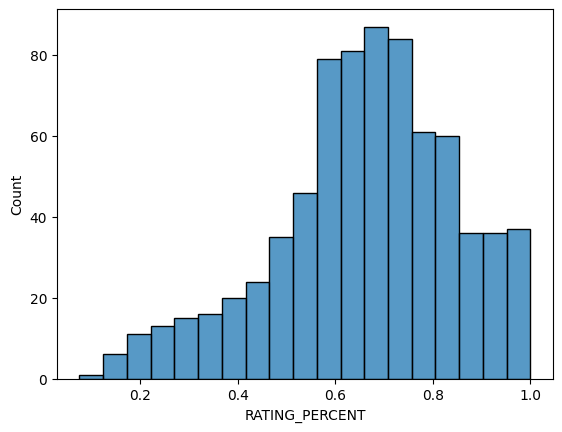

In [45]:
sns.histplot(film_ratings_df['RATING_PERCENT'])

C:\Users\tomdevine\AppData\Local\Temp\ipykernel_43336\3568918750.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(film_ratings_df['RATING_SCALED'])


<Axes: xlabel='RATING_SCALED', ylabel='Density'>

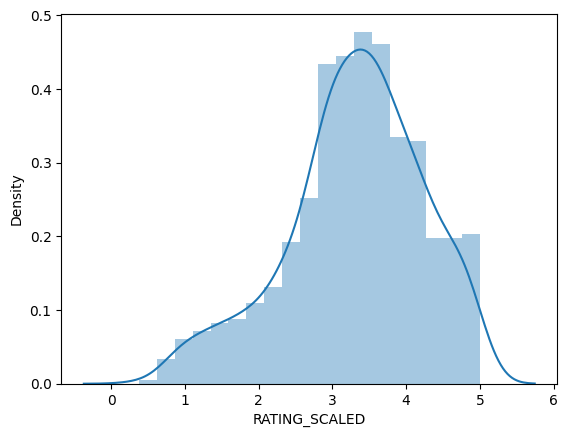

In [47]:
sns.distplot(film_ratings_df['RATING_SCALED'])

In [48]:
def barplot_mean(df, group_col, mean_col, minimum_grouping_count=None):
    df[group_col] = df[group_col].astype(str)
    tmp = df.groupby(group_col).agg({mean_col:['mean', 'count']}).reset_index()
    tmp = tmp[tmp[group_col] != '']
    tmp.columns = ['_'.join(col) if col[0] != group_col else col[0] for col in tmp.columns]
    if minimum_grouping_count is not None:
        tmp = tmp[tmp[mean_col+'_count']>=minimum_grouping_count]
    tmp = tmp.sort_values(mean_col+'_mean', ascending=False)
    tmp[mean_col+'_count'] = tmp[mean_col+'_count'].astype('float64')
    tmp_plot = sns.barplot(data=tmp, y=group_col, x=mean_col+'_mean', hue=mean_col+'_count', dodge=False, palette='Blues')
    plt.title('mean ' + mean_col + ' grouped by ' + group_col)
    return plt.show()

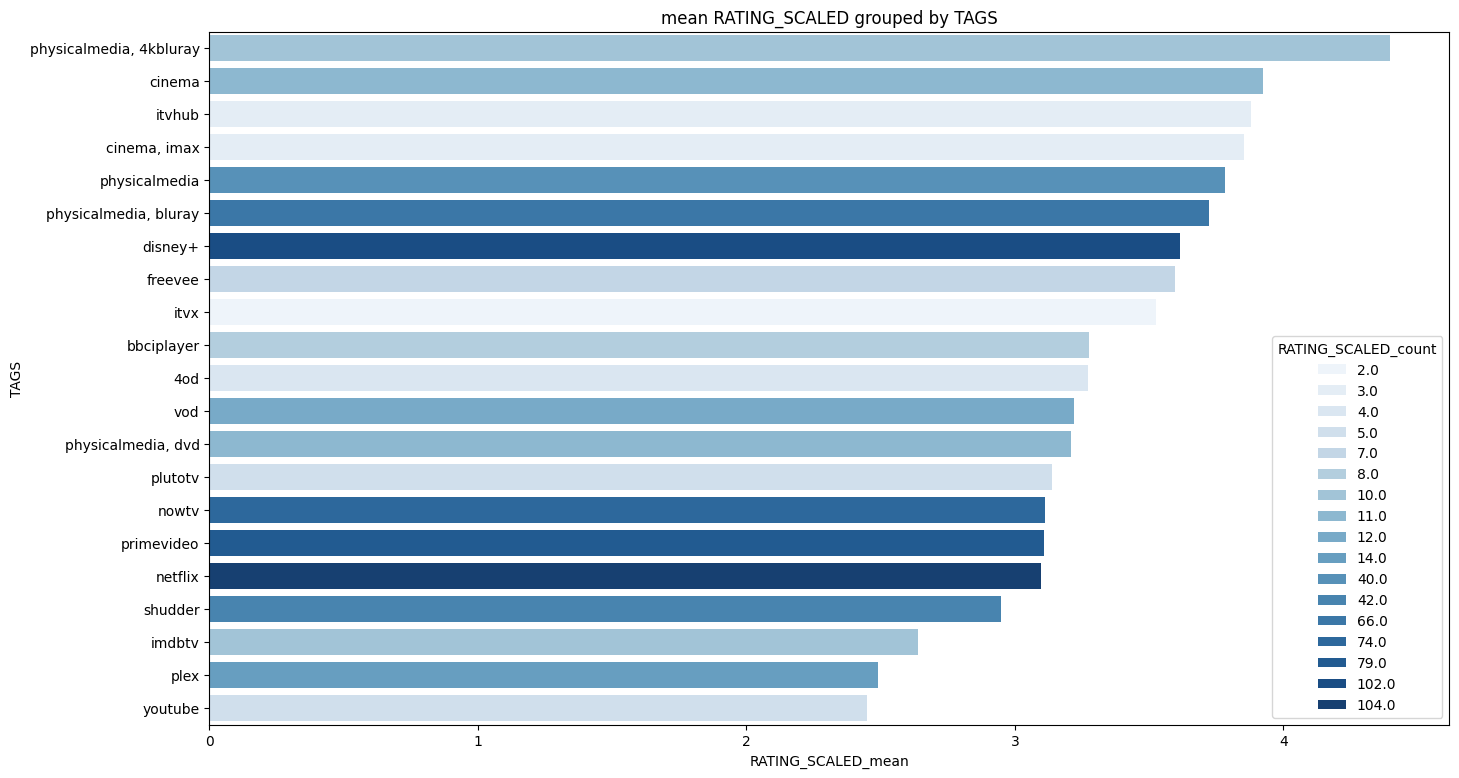

In [49]:
fig = plt.figure(figsize=(16,9))
barplot_mean(feature_diary_df, 'TAGS', 'RATING_SCALED', 2)

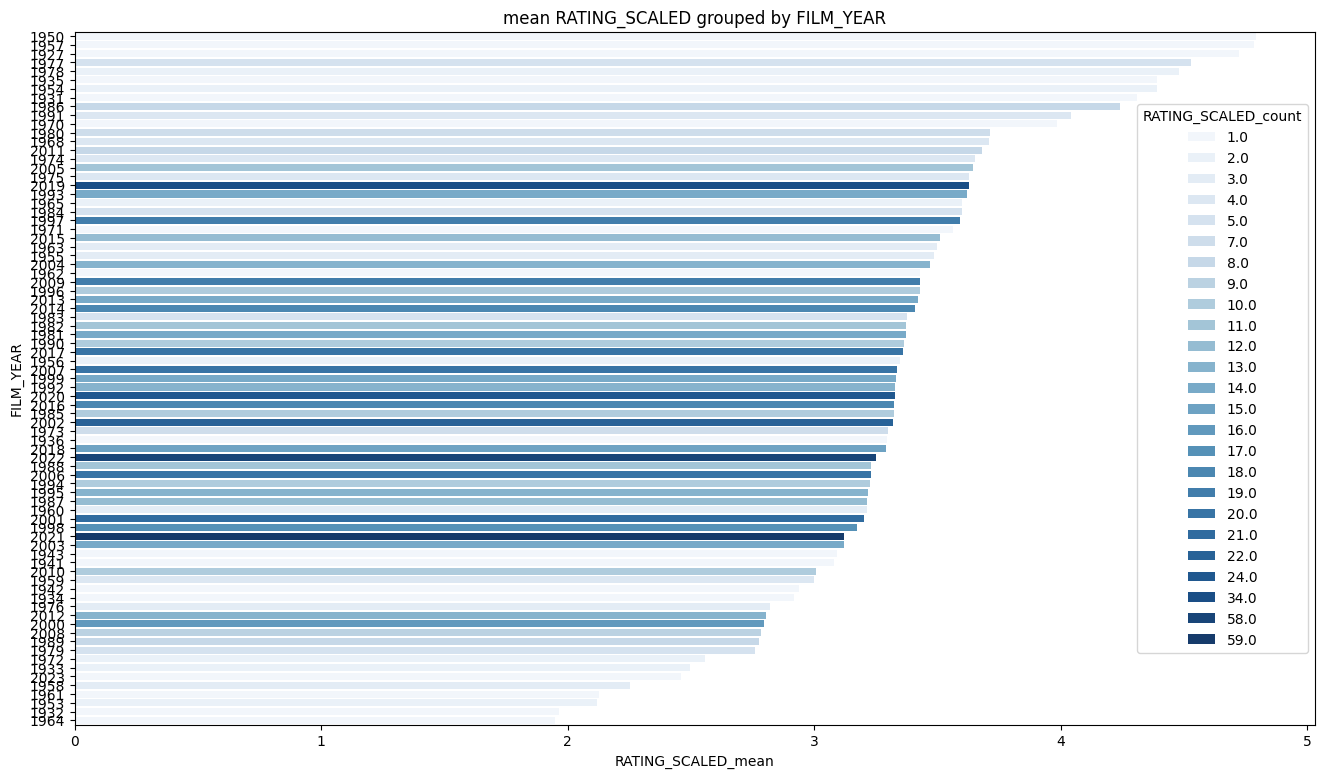

In [50]:
fig = plt.figure(figsize=(16,9))
barplot_mean(feature_diary_df, 'FILM_YEAR', 'RATING_SCALED', 0)

In [52]:
film_ratings_df[film_ratings_df['FILM_YEAR']=='2001']

,FILM_NAME,FILM_ID,FILM_YEAR,FILM_RATING,RATING_SCALED,RATING_PERCENT
78,Amélie,f_02aUc,2001,4.5,4.472973,0.894595
94,"Monsters, Inc.",f_02a46,2001,4.5,4.364865,0.872973
101,Spirited Away,f_02b4m,2001,4.5,4.317568,0.863514
112,The Devil's Backbone,f_028Li,2001,4.0,4.250000,0.850000
132,Jason X,f_01TM6,2001,4.0,4.174000,0.834800
160,The Royal Tenenbaums,f_01YHU,2001,4.0,4.062000,0.812400
181,Ocean's Eleven,f_02aZm,2001,4.0,3.978000,0.795600
258,Harry Potter and the Philosopher's Stone,f_029QS,2001,3.5,3.696629,0.739326
303,Ghosts of Mars,f_01Xik,2001,3.5,3.570225,0.714045
316,Shrek,f_029zi,2001,3.5,3.533708,0.706742


,rating,film_count,rating_str
0,5.0,37.0,5.0 stars
1,4.5,74.0,4.5 stars
2,4.0,125.0,4.0 stars
3,3.5,178.0,3.5 stars
4,3.0,163.0,3.0 stars
5,2.5,72.0,2.5 stars
6,2.0,40.0,2.0 stars
7,1.5,31.0,1.5 stars
8,1.0,23.0,1.0 stars
9,0.5,2.0,0.5 stars


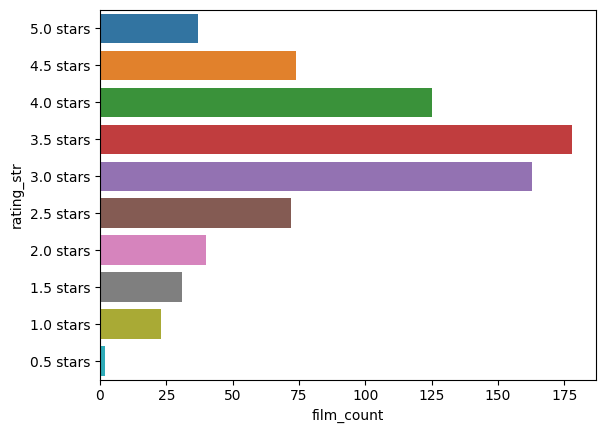

In [53]:
ratings_df = pd.DataFrame(ratings_dict).T.reset_index()[['index', 'RATING_COUNT']]
ratings_df.columns = ['rating', 'film_count']
ratings_df['rating_str'] = ratings_df['rating'].astype(str) + ' stars'
sns.barplot(data=ratings_df, y='rating_str', x='film_count', orient='h')
ratings_df

In [54]:
feature_diary_df

,WATCH_DATE,FILM_NAME,FILM_YEAR,FILM_RATING,REWATCH,TAGS,FILM_ID,LETTERBOXD_URI,FIRST_TIME_WATCH,TAG_COUNT,FILM_POSITION,NARRATIVE_FEATURE,RATING_ADJUSTED,RATING_PERCENT,RATING_SCALED
0,2021-01-01,Jumanji,1995,2.5,0,,f_01ZLI,https://boxd.it/1ZLI,1,1,610,1,2.548611,0.509722,2.548611
1,2021-01-01,Fatal Attraction,1987,4.0,0,,f_01UTC,https://boxd.it/1UTC,1,1,223,1,3.814000,0.762800,3.814000
2,2021-01-02,Punch-Drunk Love,2002,3.0,0,physicalmedia,f_020E4,https://boxd.it/20E4,1,1,458,1,3.127301,0.625460,3.127301
3,2021-01-02,Altered States,1980,4.0,0,physicalmedia,f_01TBi,https://boxd.it/1TBi,1,1,149,1,4.110000,0.822000,4.110000
4,2021-01-03,The Skin I Live In,2011,3.0,0,physicalmedia,f_0099A,https://boxd.it/99A,1,1,518,1,2.943252,0.588650,2.943252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2023-03-28,Triangle of Sadness,2022,3.0,0,primevideo,f_0hXlq,https://boxd.it/hXlq,1,1,426,1,3.225460,0.645092,3.225460
758,2023-03-29,Case 39,2009,2.5,0,netflix,f_01pMq,https://boxd.it/1pMq,1,1,613,1,2.527778,0.505556,2.527778
759,2023-03-31,The Wicker Man,1973,4.0,1,physicalmedia,f_01KnG,https://boxd.it/1KnG,0,1,138,1,4.154000,0.830800,4.154000
760,2023-03-31,The Fast and the Furious,2001,2.5,0,itvx,f_01XMu,https://boxd.it/1XMu,1,1,592,1,2.673611,0.534722,2.673611


In [56]:
ordered__film_list = feature_diary_df[['FILM_NAME', 'FILM_POSITION', 'FILM_RATING', 'RATING_SCALED']].groupby(['FILM_NAME', 'FILM_POSITION', 'FILM_RATING']).mean().sort_values('RATING_SCALED', ascending=False).reset_index()
ordered__film_list.iloc[200:220, :]

,FILM_NAME,FILM_POSITION,FILM_RATING,RATING_SCALED
200,The Beyond,201,4.0,3.902
201,Zootopia,202,4.0,3.898
202,Drop Dead Fred,203,4.0,3.894
203,Sound of Metal,204,4.0,3.890
204,The Menu,205,4.0,3.886
205,Pig,206,4.0,3.882
206,Tenebre,207,4.0,3.878
207,All Quiet on the Western Front,208,4.0,3.874
208,Kimi,209,4.0,3.870
209,Speed,210,4.0,3.866


In [57]:
watched_df = pd.read_csv(os.path.join(latest_export_file_loc, 'watched.csv'))
watched_df.columns = ['WATCH_DATE', 'FILM_NAME', 'FILM_YEAR', 'URI']
watched_df['FILM_ID'] = watched_df['URI'].apply(convert_uri_to_id)
watched_df['WATCHED'] = 1
watched_df

,WATCH_DATE,FILM_NAME,FILM_YEAR,URI,FILM_ID,WATCHED
0,2021-01-02,Jumanji,1995,https://boxd.it/1ZLI,f_01ZLI,1
1,2021-01-02,Fatal Attraction,1987,https://boxd.it/1UTC,f_01UTC,1
2,2021-01-03,Punch-Drunk Love,2002,https://boxd.it/20E4,f_020E4,1
3,2021-01-03,Altered States,1980,https://boxd.it/1TBi,f_01TBi,1
4,2021-01-03,The Fear of God: 25 Years of The Exorcist,1998,https://boxd.it/3z48,f_03z48,1
...,...,...,...,...,...,...
2328,2023-04-01,The Fast and the Furious,2001,https://boxd.it/1XMu,f_01XMu,1
2329,2023-04-01,Hannah Montana: The Movie,2009,https://boxd.it/1Hx4,f_01Hx4,1
2330,2023-04-02,2 Fast 2 Furious,2003,https://boxd.it/2a4g,f_02a4g,1
2331,2023-04-02,The Castle of the Living Dead,1964,https://boxd.it/1peS,f_01peS,1


In [58]:
watchlist_df = pd.read_csv(os.path.join(latest_export_file_loc, 'watchlist.csv'))
watchlist_df.columns = ['DATE_ADDED', 'FILM_NAME', 'FILM_YEAR', 'URI']
watchlist_df['FILM_ID'] = watchlist_df['URI'].apply(convert_uri_to_id)
watchlist_df['WATCHED'] = 0
watchlist_df

,DATE_ADDED,FILM_NAME,FILM_YEAR,URI,FILM_ID,WATCHED
0,2021-01-13,Strange Days,1995.0,https://boxd.it/2aGO,f_02aGO,0
1,2021-01-13,The Lawnmower Man,1992.0,https://boxd.it/1WVK,f_01WVK,0
2,2021-01-13,Hackers,1995.0,https://boxd.it/1WhU,f_01WhU,0
3,2021-01-13,Judge Dredd,1995.0,https://boxd.it/1Yzm,f_01Yzm,0
4,2021-01-13,The 6th Day,2000.0,https://boxd.it/207Y,f_0207Y,0
...,...,...,...,...,...,...
5405,2023-04-02,Requiem,2021.0,https://boxd.it/CxWW,f_0CxWW,0
5406,2023-04-02,Sweeney Todd: The Demon Barber of Fleet Street,2014.0,https://boxd.it/9tt4,f_09tt4,0
5407,2023-04-02,The Whip and the Body,1963.0,https://boxd.it/1rl2,f_01rl2,0
5408,2023-04-02,Satan's Slaves,2017.0,https://boxd.it/gJ1E,f_0gJ1E,0


In [59]:
all_films_df = pd.concat([watched_df.drop(['WATCH_DATE'], axis=1), watchlist_df.drop(['DATE_ADDED'], axis=1)])
all_films_df.head()

,FILM_NAME,FILM_YEAR,URI,FILM_ID,WATCHED
0,Jumanji,1995.0,https://boxd.it/1ZLI,f_01ZLI,1
1,Fatal Attraction,1987.0,https://boxd.it/1UTC,f_01UTC,1
2,Punch-Drunk Love,2002.0,https://boxd.it/20E4,f_020E4,1
3,Altered States,1980.0,https://boxd.it/1TBi,f_01TBi,1
4,The Fear of God: 25 Years of The Exorcist,1998.0,https://boxd.it/3z48,f_03z48,1


In [62]:
pd.options.display.max_rows = 9999

In [63]:
all_films_df[all_films_df['FILM_YEAR']==1991]

,FILM_NAME,FILM_YEAR,URI,FILM_ID,WATCHED
32,Drop Dead Fred,1991.0,https://boxd.it/1Wpu,f_01Wpu,1
71,The Silence of the Lambs,1991.0,https://boxd.it/2aHW,f_02aHW,1
95,Terminator 2: Judgment Day,1991.0,https://boxd.it/2aGY,f_02aGY,1
298,Cape Fear,1991.0,https://boxd.it/28vu,f_028vu,1
1192,Beauty and the Beast,1991.0,https://boxd.it/1XhG,f_01XhG,1
1193,The Addams Family,1991.0,https://boxd.it/267g,f_0267g,1
1194,Hook,1991.0,https://boxd.it/29nQ,f_029nQ,1
1195,Boyz n the Hood,1991.0,https://boxd.it/29Ug,f_029Ug,1
1196,The Rocketeer,1991.0,https://boxd.it/1WIG,f_01WIG,1
1197,The Fisher King,1991.0,https://boxd.it/2aWM,f_02aWM,1


In [65]:
year_completion_df = all_films_df.groupby('FILM_YEAR').agg({'WATCHED': ['mean', 'count']}).reset_index()
year_completion_df.columns = ['FILM_YEAR', 'COMPLETION_PERCENT', 'TOTAL_FILMS']
year_completion_df2 = year_completion_df[(year_completion_df['FILM_YEAR'] >= 1930) & (year_completion_df['FILM_YEAR'] <= 2022)]
year_completion_df2.sort_values(['COMPLETION_PERCENT', 'FILM_YEAR'], ascending=False)

,FILM_YEAR,COMPLETION_PERCENT,TOTAL_FILMS
106,2017.0,0.458647,266
108,2019.0,0.449324,296
105,2016.0,0.447826,230
93,2004.0,0.411348,141
103,2014.0,0.409283,237
101,2012.0,0.408840,181
22,1933.0,0.400000,5
91,2002.0,0.386861,137
102,2013.0,0.384259,216
99,2010.0,0.379518,166


In [69]:
year_completion_df2

,FILM_YEAR,COMPLETION_PERCENT,TOTAL_FILMS
19,1930.0,0.000000,2
20,1931.0,0.375000,8
21,1932.0,0.200000,10
22,1933.0,0.400000,5
23,1934.0,0.333333,3
24,1935.0,0.166667,6
25,1936.0,0.125000,8
26,1937.0,0.166667,6
27,1938.0,0.000000,4
28,1939.0,0.090909,11


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92]),
 [Text(0, 0, '1930.0'),
  Text(1, 0, '1931.0'),
  Text(2, 0, '1932.0'),
  Text(3, 0, '1933.0'),
  Text(4, 0, '1934.0'),
  Text(5, 0, '1935.0'),
  Text(6, 0, '1936.0'),
  Text(7, 0, '1937.0'),
  Text(8, 0, '1938.0'),
  Text(9, 0, '1939.0'),
  Text(10, 0, '1940.0'),
  Text(11, 0, '1941.0'),
  Text(12, 0, '1942.0'),
  Text(13, 0, '1943.0'),
  Text(14, 0, '1944.0'),
  Text(15, 0, '1945.0'),
  Text(16, 0, '1946.0'),
  Text(17, 0, '1947.0'),
  Text(18, 0, '1948.0'),
  Text(19, 0, '1949.0'),
  Text(20, 0, '1950.0'),
  Text(21, 0, '1951.0'),
  Text(22, 0, '1952.0'),
  Text(23, 0,

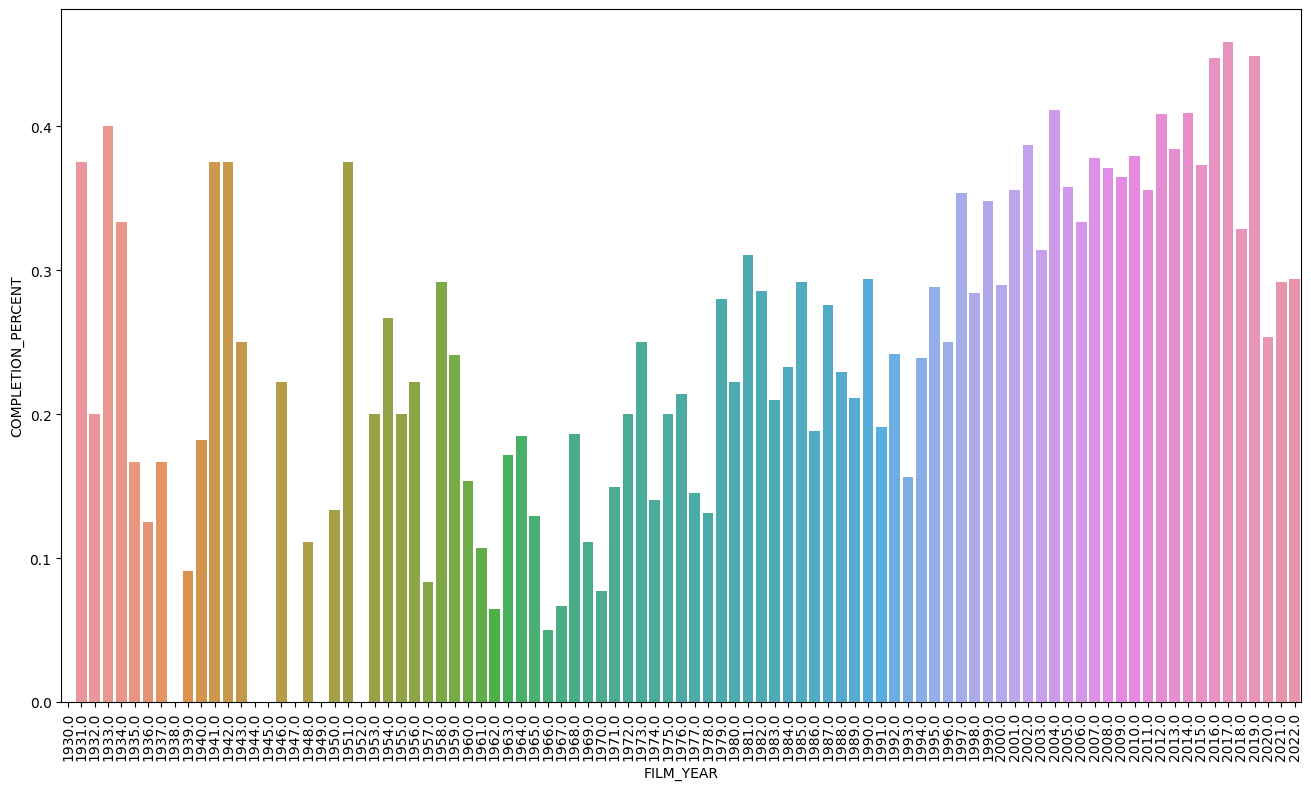

In [71]:
fig = plt.figure(figsize=(16,9))
sns.barplot(data=year_completion_df2, x='FILM_YEAR', y='COMPLETION_PERCENT')
plt.xticks(rotation=90)

In [5]:
from tmdbv3api import TMDb

tmdb_api_key = os.getenv('TMDB_API_KEY')

tmdb = TMDb()
tmdb.api_key = tmdb_api_key

In [6]:
from tmdbv3api import Movie
movie = Movie()

m = movie.details(9276)

print(m.title)
print(m.overview)
print(m.popularity)

The Faculty
When some very creepy things start happening around school, the kids at Herrington High make the chilling discovery that their faculty is being controlled by body-snatching aliens.
20.298


In [17]:
required_keys = [
                 'belongs_to_collection',
                 'budget',
                 'imdb_id',
                 'original_language',
                 'popularity',
                 'release_date',
                 'revenue',
                 'runtime',
                 'status',
                 'vote_average',
                 'vote_count',
                 'keywords',
                 'casts'
                 ]

In [18]:
movie_dict = {}
for k in required_keys:
    movie_dict[k] = m[k]
    print(k, ': ', m[k])

belongs_to_collection :  None
budget :  15000000
imdb_id :  tt0133751
original_language :  en
popularity :  20.298
release_date :  1998-12-25
revenue :  40283321
runtime :  104
status :  Released
vote_average :  6.5
vote_count :  1675
keywords :  {'keywords': [{'id': 1013, 'name': 'homophobia'}, {'id': 2231, 'name': 'drug dealer'}, {'id': 2340, 'name': 'paranoia'}, {'id': 6270, 'name': 'high school'}, {'id': 9951, 'name': 'alien'}, {'id': 10508, 'name': 'teacher'}, {'id': 14909, 'name': 'alien invasion'}, {'id': 14964, 'name': 'drugs'}, {'id': 15250, 'name': 'alien infection'}, {'id': 15266, 'name': 'social status'}, {'id': 157634, 'name': 'parasite'}, {'id': 158126, 'name': 'creature feature'}, {'id': 171461, 'name': 'school nurse'}, {'id': 191331, 'name': 'body snatchers'}, {'id': 220392, 'name': 'alien parasites'}, {'id': 242619, 'name': 'parasites'}, {'id': 283085, 'name': 'body horror'}]}
casts :  {'cast': [{'adult': False, 'gender': 2, 'id': 109, 'known_for_department': 'Acting',

[{'adult': False, 'gender': 2, 'id': 109, 'known_for_department': 'Acting', 'name': 'Elijah Wood', 'original_name': 'Elijah Wood', 'popularity': 22.601, 'profile_path': '/7UKRbJBNG7mxBl2QQc5XsAh6F8B.jpg', 'cast_id': 9, 'character': 'Casey Connor', 'credit_id': '52fe44e0c3a36847f80af47f', 'order': 0},
 {'adult': False, 'gender': 2, 'id': 2299, 'known_for_department': 'Acting', 'name': 'Josh Hartnett', 'original_name': 'Josh Hartnett', 'popularity': 38.733, 'profile_path': '/dCfu2EN7FjISACcjilaJu7evwEc.jpg', 'cast_id': 4, 'character': 'Zeke Tyler', 'credit_id': '52fe44e0c3a36847f80af46b', 'order': 1},
 {'adult': False, 'gender': 1, 'id': 20387, 'known_for_department': 'Acting', 'name': 'Clea DuVall', 'original_name': 'Clea DuVall', 'popularity': 13.917, 'profile_path': '/yueygn1Lmmni7EaMQD9LslexDlu.jpg', 'cast_id': 2, 'character': "Stokely 'Stokes' Mitchell", 'credit_id': '52fe44e0c3a36847f80af463', 'order': 2},
 {'adult': False, 'gender': 1, 'id': 22123, 'known_for_department': 'Acting'

In [45]:
cast = movie_dict.get('casts').get('cast')
crew = movie_dict.get('casts').get('crew')
for k in cast[0]:
    print(k, ': ', cast[0][k])

adult :  False
gender :  2
id :  109
known_for_department :  Acting
name :  Elijah Wood
original_name :  Elijah Wood
popularity :  22.601
profile_path :  /7UKRbJBNG7mxBl2QQc5XsAh6F8B.jpg
cast_id :  9
character :  Casey Connor
credit_id :  52fe44e0c3a36847f80af47f
order :  0


In [50]:
from tmdbv3api import Person
person = Person()
person.details(109).keys()

dict_keys(['adult', 'also_known_as', 'biography', 'birthday', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'name', 'place_of_birth', 'popularity', 'profile_path', 'images'])

In [36]:
film_id = 'f_04578'


,FILM_ID,KEYWORD_ID,KEYWORD
0,f_04578,1013,homophobia
1,f_04578,2231,drug dealer
2,f_04578,2340,paranoia
3,f_04578,6270,high school
4,f_04578,9951,alien
5,f_04578,10508,teacher
6,f_04578,14909,alien invasion
7,f_04578,14964,drugs
8,f_04578,15250,alien infection
9,f_04578,15266,social status


In [78]:
'https://image.tmdb.org/t/p/original' + '/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg'

'https://image.tmdb.org/t/p/original/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg'

In [7]:
for k in m.keys():
    # if k in required_keys:
    print('\n{} = {}'.format(k, m[k]))
    

    


adult = False

backdrop_path = /dzFPs6fXRrWIhUhE671lOSCuTnT.jpg

belongs_to_collection = None

budget = 15000000

genres = [{'id': 27, 'name': 'Horror'}, {'id': 878, 'name': 'Science Fiction'}, {'id': 9648, 'name': 'Mystery'}]

homepage = https://www.miramax.com/movie/the-faculty

id = 9276

imdb_id = tt0133751

original_language = en

original_title = The Faculty

overview = When some very creepy things start happening around school, the kids at Herrington High make the chilling discovery that their faculty is being controlled by body-snatching aliens.

popularity = 20.298

poster_path = /l0rz4vB0FfxraTd1mLGoaydSQd1.jpg

production_companies = [{'id': 11705, 'logo_path': None, 'name': 'Los Hooligans Productions', 'origin_country': ''}]

production_countries = [{'iso_3166_1': 'US', 'name': 'United States of America'}]

release_date = 1998-12-25

revenue = 40283321

runtime = 104

spoken_languages = [{'english_name': 'English', 'iso_639_1': 'en', 'name': 'English'}]

status = Released


In [7]:

m2 = movie.details(104846)

print(m2.title)
print(m2.overview)
print(m2.popularity)

The Fear of God: 25 Years of The Exorcist
A behind-the-scenes retrospective made for the twenty-fifth anniversary of the classic horror film, The Exorcist. Includes interviews with Linda Blair and the other stars of the film, along with commentary from the director and writer on some of the deeper meanings behind the elements they used to terrify their audiences, and previously unreleased footage including make-up tests and deleted scenes.
19.675


In [8]:
for k in m2.keys():
    # if k in required_keys:
    print('\n{} = {}'.format(k, m2[k]))
    


adult = False

backdrop_path = /jM8kO93Zs6eN1eK0DU5ZxsHZ2MI.jpg

belongs_to_collection = None

budget = 0

genres = [{'id': 99, 'name': 'Documentary'}, {'id': 10770, 'name': 'TV Movie'}]

homepage = http://theexorcist.warnerbros.com/

id = 104846

imdb_id = tt0237235

original_language = en

original_title = The Fear of God: 25 Years of The Exorcist

overview = A behind-the-scenes retrospective made for the twenty-fifth anniversary of the classic horror film, The Exorcist. Includes interviews with Linda Blair and the other stars of the film, along with commentary from the director and writer on some of the deeper meanings behind the elements they used to terrify their audiences, and previously unreleased footage including make-up tests and deleted scenes.

popularity = 19.675

poster_path = /yEWDfJWhFuR77jlntpFGKssKLeT.jpg

production_companies = [{'id': 3324, 'logo_path': '/dqT3yOTlfJRmtvk52Ccd1O6dZ0A.png', 'name': 'BBC', 'origin_country': 'GB'}]

production_countries = [{'iso_3166_1

In [89]:
[[x['name'], x['job']] for x in m['casts']['crew'] if x['job'] == 'Director']
[x for x in m['casts']['crew'] if x['job'] == 'Director']

[{'adult': False, 'gender': 1, 'id': 9339, 'known_for_department': 'Writing', 'name': 'Lilly Wachowski', 'original_name': 'Lilly Wachowski', 'popularity': 10.102, 'profile_path': '/rCScAjSpeKA19BLNR07MqNNeeTT.jpg', 'credit_id': '571756cfc3a3687c2c000a63', 'department': 'Directing', 'job': 'Director'},
 {'adult': False, 'gender': 1, 'id': 9340, 'known_for_department': 'Writing', 'name': 'Lana Wachowski', 'original_name': 'Lana Wachowski', 'popularity': 19.978, 'profile_path': '/5KNV7YBSPTBUAIXGfIcPmbhho9w.jpg', 'credit_id': '571756c4c3a3687bc70008e9', 'department': 'Directing', 'job': 'Director'}]

In [127]:
letterboxd_url = 'https://letterboxd.com/film/the-matrix/'
r = requests.get(letterboxd_url)
redirected_url = r.url
if letterboxd_url != redirected_url:
    r = requests.get(redirected_url)
soup = BeautifulSoup(r.content, 'lxml')
og_url = soup.find('meta', {'property': 'og:url'}).get('content')

In [129]:
genre_list = [x.get('href').replace('/films/genre/', '').replace('/', '') for x in soup.findAll('a', {'class':'text-slug'}) if 'genre' in str(x.get('href'))]
genre_list

['science-fiction', 'action']

In [131]:
'/'.join(genre_list)

'science-fiction/action'

In [62]:
def tmdb_info(tmdb_movie_id):
    movie = Movie()
    response = movie.details(tmdb_movie_id)

SyntaxError: invalid syntax (752420168.py, line 4)

In [51]:
letterboxd_url = 'https://letterboxd.com/film/everything-everywhere-all-at-once/'
r = requests.get(letterboxd_url)
redirected_url = r.url
if letterboxd_url != redirected_url:
    print('Final redirected URL was {}'.format(redirected_url))
r = requests.get(redirected_url)
soup = BeautifulSoup(r.content, 'lxml')
og_url = soup.find('meta', {'property': 'og:url'}).get('content')
film = og_url.split('/')[-2]
rating_str = soup.find('meta', {'name': 'twitter:data2'}).get('content')
rating = float(rating_str.replace(' out of 5', ''))

In [87]:
j = requests.get('https://www.justwatch.com/uk/movie/' + film)
soup_j = BeautifulSoup(j.content, 'lxml')


In [254]:
soup_j.findAll('img', {'class': 'price-comparison__grid__row__icon'})

[<img alt="Apple iTunes" class="price-comparison__grid__row__icon" data-v-660b374a="" src="https://www.justwatch.com/images/icon/190848813/s100" title="Apple iTunes"/>,
 <img alt="Amazon Prime Video" class="price-comparison__grid__row__icon" data-v-660b374a="" src="https://www.justwatch.com/images/icon/52449539/s100" title="Amazon Prime Video"/>,
 <img alt="Amazon Video" class="lazyload price-comparison__grid__row__icon" data-sizes="auto" data-src="https://images.justwatch.com/icon/430993/s100" data-v-660b374a="" src="data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEKAAEALAAAAAABAAEAAAICTAEAOw==" title="Amazon Video"/>,
 <img alt="Google Play Movies" class="lazyload price-comparison__grid__row__icon" data-sizes="auto" data-src="https://images.justwatch.com/icon/169478387/s100" data-v-660b374a="" src="data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEKAAEALAAAAAABAAEAAAICTAEAOw==" title="Google Play Movies"/>,
 <img alt="Sky Store" class="lazyload price-comparison__grid__row__icon" data-sizes="a

In [137]:
import re
stream_regex = re.compile(r'streaming on \.(.*?)\. It is also possible')

In [138]:
stream_regex

re.compile(r'streaming on \.(.*?)\. It is also possible', re.UNICODE)

In [144]:
import re
s = 'Part 1. Part 2. Part 3 then more text'
re.search(r'Part 1\.(.*?)Part 3', s).group(1)
re.search(r'Part 1(.*?)Part 3', s).group(1)

'. Part 2. '

In [154]:
watched_df

NameError: name 'watched_df' is not defined

In [127]:
soup_j.find('div', {'class':'detail-infos__subheading'})
stream_text = [x.text for x in soup_j.findAll('p', {'class':'mt-0'}) if 'Currently you are able to watch' in x.text]
# <div class="detail-infos__subheading"><h2 class="detail-infos__subheading--label">Knives Out - watch online: streaming, buy or rent</h2></div>

In [100]:
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub)

In [247]:
for pos in list(find_all(str(soup_j), 'Amazon')):
    print(str(soup_j)[pos-500: pos+200])
    print('-'*99)

r" name="google-site-verification"/><meta content="d61y4roe8t5xwbb0gfu6gwe8j8iq3i" data-vue-meta="ssr" name="facebook-domain-verification"/><meta content="dmorpwc4h544ct6mv" data-vue-meta="ssr" name="dailymotion-domain-verification"/><meta content="Everything Everywhere All at Once - streaming" data-vue-meta="ssr" property="og:title"/><meta content="Everything Everywhere All at Once, 2022, streaming, online, download, watch, movie" data-vue-meta="ssr" name="keywords"/><meta content="Is Netflix, Amazon, Now TV, ITV, iTunes, etc. streaming Everything Everywhere All at Once? Find it online now!" data-vue-meta="ssr" name="description"/><meta content="Is Netflix, Amazon, Now TV, ITV, iTunes, etc.
---------------------------------------------------------------------------------------------------
ct6mv" data-vue-meta="ssr" name="dailymotion-domain-verification"/><meta content="Everything Everywhere All at Once - streaming" data-vue-meta="ssr" property="og:title"/><meta content="Everything Eve

In [96]:
str(soup_j)[1469:1569]

'Amazon, Now TV, ITV, iTunes, etc. streaming Everything Everywhere All at Once? Find it online now!" '

In [265]:
letterboxd_url = 'https://letterboxd.com/film/everything-everywhere-all-at-once/watch'
r = requests.get(letterboxd_url)
soup = BeautifulSoup(r.content, 'lxml')

In [266]:
soup

<!DOCTYPE html>
<!--[if lt IE 7 ]> <html lang="en" class="ie6 lte9 lte8 lte7 lte6 no-js"> <![endif]--><!--[if IE 7 ]>    <html lang="en" class="ie7 lte9 lte8 lte7 no-js"> <![endif]--><!--[if IE 8 ]>    <html lang="en" class="ie8 lte9 lte8 no-js"> <![endif]--><!--[if IE 9 ]>    <html lang="en" class="ie9 lte9 no-js"> <![endif]--><!--[if (gt IE 9)|!(IE)]><!--><html class="no-mobile no-js" id="html" lang="en"> <!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="width=1024" name="viewport"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="An aging Chinese immigrant is swept up in an insane adventure, where she alone can save what's important to her by connecting with the lives she could have led in other universes." name="description"/>
<meta content="video.movie" property="og:type"/>
<meta content="https://letterboxd.com/film/everything-everywhere-all-at-once/watch/" property="og:url"/>
<meta content="Everything Everywhere All at Once (2022)" prop

In [402]:
my_streaming_services = [
    {"streaming_service": "Amazon Prime Video", "tag_value": "primevideo", "provider_abbreviation":"amp"},
    {"streaming_service": "Netflix",            "tag_value": "netflix",    "provider_abbreviation":"nfx"},
    {"streaming_service": "BBC iPlayer",        "tag_value": "bbciplayer", "provider_abbreviation":"bbc"},
    {"streaming_service": "All4",               "tag_value": "4od",        "provider_abbreviation":"al4"},
    {"streaming_service": "NowTV",              "tag_value": "nowtv",      "provider_abbreviation":"ntc"},
    {"streaming_service": "Disney+",            "tag_value": "disney+",    "provider_abbreviation":"dnp"},
    {"streaming_service": "Shudder",            "tag_value": "shudder",    "provider_abbreviation":"asd"},
    {"streaming_service": "Plex",               "tag_value": "plex",       "provider_abbreviation":"plx"},
    {"streaming_service": "PlutoTV",            "tag_value": "plutotv",    "provider_abbreviation":"ptv"},
    {"streaming_service": "My5",                "tag_value": "5od",        "provider_abbreviation":"myf"},
    {"streaming_service": "Freevee",            "tag_value": "freevee",    "provider_abbreviation":"aim"},
    {"streaming_service": "Freevee",            "tag_value": "imdbtv",     "provider_abbreviation":""},
    {"streaming_service": "ITVX",               "tag_value": "itvx",       "provider_abbreviation":"itv"},
    {"streaming_service": "ITVX",               "tag_value": "itvhub",     "provider_abbreviation":""}
]

In [410]:
my_streaming_services_abbr = [x for x in set([x['provider_abbreviation'] for x in my_streaming_services]) if len(x) > 0]
my_streaming_services_abbr

['asd',
 'nfx',
 'ntc',
 'al4',
 'plx',
 'myf',
 'bbc',
 'dnp',
 'ptv',
 'aim',
 'amp',
 'itv']

In [411]:
from justwatch import JustWatch
just_watch = JustWatch(country='GB')
film_title = 'black-narcissus'
release_year = 1947
results = just_watch.search_for_item(query=film_title, release_year_from=release_year-1, release_year_until=release_year+1)
first_result = results['items'][0]
print(first_result['title']+':')
provider_abbreviations = list(set([x['package_short_name'] for x in first_result['offers'] if x['monetization_type'] in ['flatrate', 'free', 'ads']]))
valid_abbreviations = [x for x in provider_abbreviations if x in my_streaming_services_abbr]
valid_abbreviations

Black Narcissus:


['itv']

In [395]:
abbr_lookup = 'aim'
[x for x in first_result['offers'] if x['package_short_name']==abbr_lookup]

[{'jw_entity_id': 'tm145683',
  'monetization_type': 'ads',
  'provider_id': 613,
  'package_short_name': 'aim',
  'currency': 'GBP',
  'urls': {'standard_web': 'https://watch.amazon.co.uk/detail?gti=amzn1.dv.gti.fcb8ba3b-a762-10f5-0ee2-ba1abdcfd22f',
   'deeplink_web': 'https://watch.amazon.co.uk/watch?gti=amzn1.dv.gti.fcb8ba3b-a762-10f5-0ee2-ba1abdcfd22f',
   'deeplink_rokuos': 'launch/13?contentID=B0872H33LQ&MediaType=movie'},
  'presentation_type': 'hd',
  'country': 'GB'},
 {'jw_entity_id': 'tm145683',
  'monetization_type': 'ads',
  'provider_id': 613,
  'package_short_name': 'aim',
  'currency': 'GBP',
  'urls': {'standard_web': 'https://watch.amazon.co.uk/detail?gti=amzn1.dv.gti.fcb8ba3b-a762-10f5-0ee2-ba1abdcfd22f',
   'deeplink_web': 'https://watch.amazon.co.uk/watch?gti=amzn1.dv.gti.fcb8ba3b-a762-10f5-0ee2-ba1abdcfd22f',
   'deeplink_rokuos': 'launch/13?contentID=B0872H33LQ&MediaType=movie'},
  'presentation_type': 'sd',
  'country': 'GB'}]

In [378]:
[x for x in first_result['offers'] if x['monetization_type'] in ['flatrate', 'free']]

[{'jw_entity_id': 'tm246135',
  'monetization_type': 'flatrate',
  'provider_id': 224,
  'package_short_name': 'bfi',
  'currency': 'GBP',
  'urls': {'standard_web': 'https://player.bfi.org.uk/subscription/film/watch-the-ghoul-2017-online'},
  'presentation_type': 'sd',
  'country': 'GB'},
 {'jw_entity_id': 'tm246135',
  'monetization_type': 'flatrate',
  'provider_id': 287,
  'package_short_name': 'abf',
  'currency': 'GBP',
  'urls': {'standard_web': 'https://watch.amazon.co.uk/detail?gti=amzn1.dv.gti.1caecfdb-7dc5-d196-e807-47d9c8f81c5b',
   'deeplink_web': 'https://watch.amazon.co.uk/watch?gti=amzn1.dv.gti.1caecfdb-7dc5-d196-e807-47d9c8f81c5b',
   'deeplink_rokuos': 'launch/13?contentID=B074GHDQGC&MediaType=movie'},
  'available_to': '2023-04-30',
  'presentation_type': 'hd',
  'country': 'GB'},
 {'jw_entity_id': 'tm246135',
  'monetization_type': 'flatrate',
  'provider_id': 287,
  'package_short_name': 'abf',
  'currency': 'GBP',
  'urls': {'standard_web': 'https://watch.amazon.c

In [357]:
diary_df_output['TAGS'].unique()

array(['', 'physicalmedia', 'bbciplayer', 'netflix', 'nowtv', 'disney+',
       'primevideo', 'youtube', 'vod', 'cinema', 'shudder',
       'physicalmedia, bluray', 'physicalmedia, dvd', 'imdbtv',
       'liff, liff2021, cinema', 'physicalmedia, 4kbluray', 'plex',
       'plutotv', '5od', 'cinema, imax', 'freevee', '4od',
       'cinema, lunacinema', 'itvhub', 'livetv', 'dailymotion', 'itvx'],
      dtype=object)

In [373]:
diary_df_output[diary_df_output['TAGS']=='plex']

,FILM_ID,WATCH_DATE,FILM_RATING,TAGS,FIRST_TIME_WATCH
545,f_03rou,2022-01-16,3.0,plex,1
546,f_028Ow,2022-01-16,2.5,plex,1
548,f_01M4m,2022-01-19,1.5,plex,1
550,f_00I9g,2022-01-21,3.5,plex,1
552,f_07Yxi,2022-01-24,2.5,plex,1
576,f_01Mxo,2022-02-05,4.0,plex,1
670,f_022os,2022-06-12,3.5,plex,1
697,f_01rxW,2022-07-09,1.5,plex,1
699,f_029we,2022-07-11,3.5,plex,1
702,f_039FW,2022-07-15,1.5,plex,1


In [84]:
rating_dict = json.loads(soup.find('script', {'type':"application/ld+json"}).string.split('\n')[2]).get('aggregateRating')
rating_dict#.get('ratingCount')

{'bestRating': 5,
 'reviewCount': 348995,
 '@type': 'aggregateRating',
 'ratingValue': 4.44,
 'description': 'The Letterboxd rating is a weighted average score for a movie based on all ratings cast to date by our members.',
 'ratingCount': 1021938,
 'worstRating': 0}

In [52]:
soup

<!DOCTYPE html>
<!--[if lt IE 7 ]> <html lang="en" class="ie6 lte9 lte8 lte7 lte6 no-js"> <![endif]--><!--[if IE 7 ]>    <html lang="en" class="ie7 lte9 lte8 lte7 no-js"> <![endif]--><!--[if IE 8 ]>    <html lang="en" class="ie8 lte9 lte8 no-js"> <![endif]--><!--[if IE 9 ]>    <html lang="en" class="ie9 lte9 no-js"> <![endif]--><!--[if (gt IE 9)|!(IE)]><!--><html class="no-mobile no-js" id="html" lang="en"> <!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="width=1024" name="viewport"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="An aging Chinese immigrant is swept up in an insane adventure, where she alone can save what's important to her by connecting with the lives she could have led in other universes." name="description"/>
<meta content="video.movie" property="og:type"/>
<meta content="https://letterboxd.com/film/everything-everywhere-all-at-once/" property="og:url"/>
<meta content="Everything Everywhere All at Once (2022)" property="

In [8]:
r = requests.get('https://letterboxd.com/film/{}/members/rated/.5-5/'.format('jumanji'))
soup = BeautifulSoup(r.content, 'lxml')

In [45]:
film='jumanji'
for i in ['members', 'fans', 'likes', 'reviews', 'lists']:
    href_str = '/film/{}/{}/'.format(film, i)
    metric_string = soup.find('a', {'class': 'tooltip', 'href':href_str}).get('title')
    metric = int(metric_string[:metric_string.find('\xa0')].replace(',', ''))

In [12]:
soup

<!DOCTYPE html>
<!--[if lt IE 7 ]> <html lang="en" class="ie6 lte9 lte8 lte7 lte6 no-js"> <![endif]--><!--[if IE 7 ]>    <html lang="en" class="ie7 lte9 lte8 lte7 no-js"> <![endif]--><!--[if IE 8 ]>    <html lang="en" class="ie8 lte9 lte8 no-js"> <![endif]--><!--[if IE 9 ]>    <html lang="en" class="ie9 lte9 no-js"> <![endif]--><!--[if (gt IE 9)|!(IE)]><!--><html class="no-mobile no-js" id="html" lang="en"> <!--<![endif]-->
<head>
<meta charset="utf-8"/>
<meta content="width=1024" name="viewport"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="Everyone who has watched Jumanji" name="description"/>
<meta content="https://letterboxd.com/film/jumanji/members/rated/.5-5/" property="og:url"/>
<meta content="Everyone who has watched Jumanji" property="og:title"/>
<meta content="Everyone who has watched Jumanji" property="og:description"/>
<meta content="https://s.ltrbxd.com/static/img/default-share.e38c5d62.png" property="og:image"/>
<meta content="Letterboxd

In [63]:
def letterboxd(url, verbose=False):
    headers = {
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'referer': 'https://google.com',
    }
    if verbose: print('URL requested was {}'.format(url))
    r = requests.get(url, headers=headers)
    redirected_url = r.url
    if verbose and (url != redirected_url):
        print('Final redirected URL was {}'.format(redirected_url))
    r = requests.get(redirected_url, headers=headers)
    content_string = str(r.content)
    soup = BeautifulSoup(r.content, 'lxml')

    item = {}
    
    title = soup.find('meta', {'property': 'og:title'}).get('content')
    cast = [cast.text for cast in soup.find_all('a', {'class': 'text-slug tooltip'})]
    characters = [str(cast)[str(cast).find('title=')+7:str(cast).find(">")-1] for cast in soup.find_all('a', {'class': 'text-slug tooltip'})]
    directors = [directors.text for directors in soup.find_all('span', {'class': 'prettify'})]
    rating = soup.find('meta', {'name': 'twitter:data2'}).get('content')
    directors = soup.find_all('div', {'class': 'text-sluglist'})[1]
    directors = [directors.text for directors in directors.find_all('a')]
    producers = soup.find_all('div', {'class': 'text-sluglist'})[2]
    producers = [producers.text for producers in producers.find_all('a')]
    writers = soup.find_all('div', {'class': 'text-sluglist'})[3]
    writers = [writers.text for writers in writers.find_all('a')]
    editors = soup.find_all('div', {'class': 'text-sluglist'})[4]
    editors = [editors.text for editors in editors.find_all('a')]
    cinematographers = soup.find_all('div', {'class': 'text-sluglist'})[5]
    cinematographers = [cinematographers.text for cinematographers in cinematographers.find_all('a')]
    composers = soup.find_all('div', {'class': 'text-sluglist'})[10]
    composers = [composers.text for composers in composers.find_all('a')]
    studios = soup.find_all('div', {'class': 'text-sluglist'})[14]
    studios = [studios.text for studios in studios.find_all('a')]
    countries = soup.find_all('div', {'class': 'text-sluglist'})[15]
    countries = [countries.text for countries in countries.find_all('a')]
    languages = soup.find_all('div', {'class': 'text-sluglist'})[16]
    languages = [languages.text for languages in languages.find_all('a')]
    genres = soup.find_all('div', {'class': 'text-sluglist'})[17]
    genres = [genres.text for genres in genres.find_all('a')]
    themes = soup.find_all('div', {'class': 'text-sluglist'})[18]
    themes = [themes.text for themes in themes.find_all('a')]
    
    
    year = soup.find('small', {'class': 'number'}).text
    
    film_length_start = content_string[content_string.find('<p class="text-link text-footer">')+57:]
    film_length = film_length_start[:film_length_start.find('&nbsp')]
    lazy_load_pos = content_string.find('really-lazy-load poster')
    img_src_0 = lazy_load_pos + content_string[lazy_load_pos:].find('<img src="') + 10
    img_src_1 = img_src_0 + content_string[img_src_0:].find('"')
    img_url = content_string[img_src_0:img_src_1]
    
    
    id_loc_0 = content_string.find('id: ') + 4
    id_loc_1 = content_string.find(',', id_loc_0)
    film_id = 'id_'+content_string[id_loc_0:id_loc_1].zfill(9)
    
    item['unique_id'] = film_id
    item['title'] = title
    item['release_year'] = year
    item['film_length'] = film_length
    item['director'] = directors
    item['cast'] = cast
    item['characters'] = characters
    item['rating'] = rating
    item['genres'] = genres
    item['producers'] = producers
    item['writers'] = writers
    item['editors'] = editors
    item['cinematographers'] = cinematographers
    item['composers'] = composers
    item['studios'] = studios
    item['countries'] = countries
    item['languages'] = languages
    item['themes'] = themes
    
    item['imgurl'] = img_url
    
    og_url = soup.find('meta', {'property': 'og:url'}).get('content')
    film = og_url.split('/')[-2]

    r2 = requests.get('https://letterboxd.com/esi/film/{}/stats/'.format(film), headers=headers)

    soup2 = BeautifulSoup(r2.content, 'lxml')


    watched_by = str(soup2)[str(soup2).find('Watched by ')+11:str(soup2).find('Watched by ')+25]
    watched_by = int(watched_by[0:watched_by.find('\xa0m')].replace(',',''))
    
    listed_by = str(soup2)[str(soup2).find('Appears in ')+11:str(soup2).find('Appears in ')+25]
    listed_by = int(listed_by[0:listed_by.find('\xa0l')].replace(',',''))
    liked_by = str(soup2)[str(soup2).find('Appears in ')+11:str(soup2).find('Appears in ')+25]
    liked_by = int(liked_by[0:liked_by.find('\xa0l')].replace(',',''))

    try:
        top_ = int(soup2.find('a', {'class': 'has-icon icon-top250 icon-16 tooltip'}).text)
    except:
        top_ = None

    item['watch_count'] = watched_by
    item['list_count'] = listed_by
    item['like_count'] = liked_by
    item['top250'] = top_
    item['datacollection_timestamp'] = datetime.datetime.now()
    
    return item

test_film = letterboxd('https://letterboxd.com/film/the-matrix/')
test_film

{'unique_id': 'id_000051518',
 'title': 'The Matrix (1999)',
 'release_year': '1999',
 'film_length': '136',
 'director': ['Lilly Wachowski', 'Lana Wachowski'],
 'cast': ['Keanu Reeves',
  'Laurence Fishburne',
  'Carrie-Anne Moss',
  'Hugo Weaving',
  'Joe Pantoliano',
  'Marcus Chong',
  'Anthony Ray Parker',
  'Matt Doran',
  'Gloria Foster',
  'Belinda McClory',
  'Paul Goddard',
  'Robert Taylor',
  'Ada Nicodemou',
  'Julian Arahanga',
  'David Aston',
  'Marc Aden Gray',
  'Deni Gordon',
  'Rowan Witt',
  'Eleanor Witt',
  'Janaya Pender',
  'Adryn White',
  'Natalie Tjen',
  'Bill Young',
  "David O'Connor",
  'Jeremy Ball',
  'Fiona Johnson',
  'Harry Lawrence',
  'Steve Dodd',
  'Luke Quinton',
  'Lawrence Woodward',
  'Michael Butcher',
  'Bernard Ledger',
  'Chris Pattinson',
  'Robert Simper',
  'Nigel Harbach',
  'Rana Morrison',
  'Tamara Brown'],
 'characters': ['Thomas A. Anderson / Neo',
  'Morpheus',
  'Trinity',
  'Agent Smith',
  'Cypher',
  'Tank',
  'Dozer',
  'M

In [64]:
url = 'https://letterboxd.com/film/the-matrix/'
headers = {
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'referer': 'https://google.com',
    }
r = requests.get(url, headers=headers)
redirected_url = r.url
if (url != redirected_url):
    print('Final redirected URL was {}'.format(redirected_url))
r = requests.get(redirected_url, headers=headers)
content_string = str(r.content)

In [65]:
#cinematographers = 
BeautifulSoup(r.content, 'lxml').find_all('p', {'class': 'text-link text-footer'})[0].find_all('a')




[<a class="micro-button track-event" data-track-action="IMDb" href="http://www.imdb.com/title/tt0133093/maindetails">IMDb</a>,
 <a class="micro-button track-event" data-track-action="TMDb" href="https://www.themoviedb.org/movie/603/">TMDb</a>]

In [66]:
print(content_string[:666])

b'\n\n<!DOCTYPE html>\n\n<!--[if lt IE 7 ]> <html lang="en" class="ie6 lte9 lte8 lte7 lte6 no-js"> <![endif]-->\n<!--[if IE 7 ]>    <html lang="en" class="ie7 lte9 lte8 lte7 no-js"> <![endif]-->\n<!--[if IE 8 ]>    <html lang="en" class="ie8 lte9 lte8 no-js"> <![endif]-->\n<!--[if IE 9 ]>    <html lang="en" class="ie9 lte9 no-js"> <![endif]-->\n<!--[if (gt IE 9)|!(IE)]><!--> <html id="html" lang="en" class="no-mobile no-js"> <!--<![endif]-->\n<head>\n\t<meta charset="UTF-8" />\n\t<meta name="viewport" content="width=1024" />\n\t<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1" />\n\t<meta name="description" content="Set in the 22nd century, The M


In [67]:
len('<div class="text-sluglist capitalize"')

37

In [69]:
text_upto = content_string[content_string.find('<div class="text-sluglist capitalize"'):]
text = text_upto[:text_upto.find('&nbsp')]
text_upto

'<div class="text-sluglist capitalize">\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<p>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<a href="/films/genre/science-fiction/" class="text-slug">science-fiction</a> <a href="/films/genre/action/" class="text-slug">action</a> \\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t</p>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t</div>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\n\\t\\t\\t\\t\\t\\t\\t\\t\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t<h3><span>Themes</span></h3>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t<div class="text-sluglist capitalize">\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<p>\\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<a href="/films/theme/monsters-aliens-sci-fi-and-the-apocalypse/by/best-match/" class="text-slug">Monsters, aliens, sci-fi and the apocalypse</a> <a href="/films/theme/epic-heroes/by/best-match/" class="text-slug">Epic heroes</a> \\n\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t\\t<a href="/films/mini-theme/future-action-technology-technological-humanity/by/best-match/" class="text-slug">future, sci-fi, technology, action or technological

In [70]:
def grab_img_from_url(url, resize=True, output_size=(256, 256), display_img=False):
    image = Image.open(requests.get(url, stream=True).raw)
    if resize:
        image.thumbnail(output_size)
    if display_img:
        display(image)
    return image

In [71]:
def save_img(pil_img, save_loc):
    try:
        pil_img.save(save_loc)
        return print('Save Successful')
    except:
        return print('Save Unsuccessful')

In [72]:
file_loc = os.path.join(data_loc, 'Posters', 'matrix'+'.jpeg')

In [74]:
tmp_img = grab_img_from_url(test_film['imgurl'], resize=True)

In [76]:
test_film['imgurl']

'https://s.ltrbxd.com/static/img/empty-poster-230.876e6b8e.png'

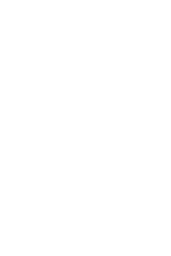

In [75]:
tmp_img

In [ ]:
def letterboxd(url, verbose=False):
    headers = {
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'referer': 'https://google.com',
    }
    if verbose: print('URL requested was {}'.format(url))
    r = requests.get(url, headers=headers)
    redirected_url = r.url
    if verbose and (url != redirected_url):
        print('Final redirected URL was {}'.format(redirected_url))
    r = requests.get(redirected_url, headers=headers)
    content_string = str(r.content)
    soup = BeautifulSoup(r.content, 'lxml')

    item = {}
    
    title = soup.find('meta', {'property': 'og:title'}).get('content')
    cast = [cast.text for cast in soup.find_all('a', {'class': 'text-slug tooltip'})]
    characters = [str(cast)[str(cast).find('title=')+7:str(cast).find(">")-1] for cast in soup.find_all('a', {'class': 'text-slug tooltip'})]
    directors = [directors.text for directors in soup.find_all('span', {'class': 'prettify'})]
    rating = soup.find('meta', {'name': 'twitter:data2'}).get('content')
    directors = soup.find_all('div', {'class': 'text-sluglist'})[1]
    directors = [directors.text for directors in directors.find_all('a')]
    producers = soup.find_all('div', {'class': 'text-sluglist'})[2]
    producers = [producers.text for producers in producers.find_all('a')]
    writers = soup.find_all('div', {'class': 'text-sluglist'})[3]
    writers = [writers.text for writers in writers.find_all('a')]
    editors = soup.find_all('div', {'class': 'text-sluglist'})[4]
    editors = [editors.text for editors in editors.find_all('a')]
    cinematographers = soup.find_all('div', {'class': 'text-sluglist'})[5]
    cinematographers = [cinematographers.text for cinematographers in cinematographers.find_all('a')]
    composers = soup.find_all('div', {'class': 'text-sluglist'})[10]
    composers = [composers.text for composers in composers.find_all('a')]
    studios = soup.find_all('div', {'class': 'text-sluglist'})[14]
    studios = [studios.text for studios in studios.find_all('a')]
    countries = soup.find_all('div', {'class': 'text-sluglist'})[15]
    countries = [countries.text for countries in countries.find_all('a')]
    languages = soup.find_all('div', {'class': 'text-sluglist'})[16]
    languages = [languages.text for languages in languages.find_all('a')]
    genres = soup.find_all('div', {'class': 'text-sluglist'})[17]
    genres = [genres.text for genres in genres.find_all('a')]
    themes = soup.find_all('div', {'class': 'text-sluglist'})[18]
    themes = [themes.text for themes in themes.find_all('a')]
    
    
    year = soup.find('small', {'class': 'number'}).text
    
    film_length_start = content_string[content_string.find('<p class="text-link text-footer">')+57:]
    film_length = film_length_start[:film_length_start.find('&nbsp')]
    lazy_load_pos = content_string.find('really-lazy-load poster')
    img_src_0 = lazy_load_pos + content_string[lazy_load_pos:].find('<img src="') + 10
    img_src_1 = img_src_0 + content_string[img_src_0:].find('"')
    img_url = content_string[img_src_0:img_src_1]
    
    
    id_loc_0 = content_string.find('id: ') + 4
    id_loc_1 = content_string.find(',', id_loc_0)
    film_id = 'id_'+content_string[id_loc_0:id_loc_1].zfill(9)
    
    item['unique_id'] = film_id
    item['title'] = title
    item['release_year'] = year
    item['film_length'] = film_length
    item['director'] = directors
    item['cast'] = cast
    item['characters'] = characters
    item['rating'] = rating
    item['genres'] = genres
    item['producers'] = producers
    item['writers'] = writers
    item['editors'] = editors
    item['cinematographers'] = cinematographers
    item['composers'] = composers
    item['studios'] = studios
    item['countries'] = countries
    item['languages'] = languages
    item['themes'] = themes
    
    item['imgurl'] = img_url
    
    og_url = soup.find('meta', {'property': 'og:url'}).get('content')
    film = og_url.split('/')[-2]

    r2 = requests.get('https://letterboxd.com/esi/film/{}/stats/'.format(film), headers=headers)

    soup2 = BeautifulSoup(r2.content, 'lxml')

    watched_by = str(soup2)[str(soup2).find('Watched by ')+11:str(soup2).find('Watched by ')+25]
    watched_by = int(watched_by[0:watched_by.find('\xa0m')].replace(',',''))
    
    listed_by = str(soup2)[str(soup2).find('Appears in ')+11:str(soup2).find('Appears in ')+25]
    listed_by = int(listed_by[0:listed_by.find('\xa0l')].replace(',',''))
    liked_by = str(soup2)[str(soup2).find('Appears in ')+11:str(soup2).find('Appears in ')+25]
    liked_by = int(liked_by[0:liked_by.find('\xa0l')].replace(',',''))

    try:
        top_ = int(soup2.find('a', {'class': 'has-icon icon-top250 icon-16 tooltip'}).text)
    except:
        top_ = None

    item['watch_count'] = watched_by
    item['list_count'] = listed_by
    item['like_count'] = liked_by
    item['top250'] = top_
    item['datacollection_timestamp'] = datetime.datetime.now()
    
    return item

test_film = letterboxd('https://letterboxd.com/film/the-matrix/')
test_film